# 2D effective index approximation of 3D simulations

Large-scale 3D FDTD simulations are often required for accurate results but are associated with significant time and costs. Therefore, the development of methods to approximate 3D simulations using 2D models presents notable advantages. For instance, during the initial phase of design exploration, employing 2D simulations can effectively narrow down the range of parameters, with 3D simulations subsequently refining and finalizing the design.

This notebook introduces an efficient index approximation method that enables the approximation of 3D FDTD simulations through 2D simulations, substantially reducing computational resources and simulation times, potentially by orders of magnitude, while still retaining a reasonable level of accuracy. This method is particularly suitable for modeling integrated photonic devices that support waveguide modes. We first outline the process for calculating the effective permittivity for the 2D simulation using the variational method.

Following this, we compare outcomes from both 2D and 3D simulations using various real devices as examples to validate the approximation method's effectiveness. The findings indicate that, when applied appropriately, the 2D simulation maintains an acceptable fidelity to the corresponding 3D response.

<a href="https://doi.org/10.1007/s11082-009-9349-3"><img src="img/effective_index_approximation.png" width="500" alt="Schematic of 2D-ifying" ></a>

First we start by importing the necessary libraries for our simulations:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gdstk

import tidy3d as td
import tidy3d.web as web

## Variational Effective Permittivity

In order to match the material of our 2D structures with those of the corresponding 3D structures, we will calculate the <b>variational effective permittivity</b>, taken from `Manfred Hammer and Olena V. Ivanova, "Effective index approximations of photonic crystal slabs: a 2-to-1-D assessment," Opt Quant Electron 41, 267–283 (2009)`[DOI:10.1007/s11082-009-9349-3](https://doi.org/10.1007/s11082-009-9349-3):<br>
<center>
$\epsilon_{eff}(x,y)=n_{eff}(x,y)^2+\frac{\int_z[\epsilon(x,y,z)-\epsilon_{ref}(x,y,z,\omega)]|M(z,\omega)|^2dz}{\int_z|M(z,\omega)|^2dz},$
</center><br>
where $n_{eff}(x,y)$ is the effective index of the slab waveguide given the permittivity profile in the z direction, $\epsilon_{ref}$ is the reference slab permittivity profile in z, $\epsilon$ is the permittivity profile in z at the point at which you're calculating, and $M(z,\omega)$ is the mode profile in $z$. This formula is based on the assumption that the different vertical slab modes remain relatively uncoupled.<br><br>

The reference profile in $z$ is a point $(x_r,y_r)$ that we choose to compare other $z$ profiles against. In our examples, we choose this point to include the location of our waveguide. Since, at the reference point, $\epsilon(x_r,y_r,z)=\epsilon_{ref}(x_r,y_r,z)$, the effective permittivity is simply $n_{eff}(x,y)^2$. Outside the waveguide, the integrand becomes nonzero so we must carry out the integral numerically.<br><br>

Note: This is only the effective permittivity for the TE mode. A separate TM mode formula exists, and the interested user should refer to the TM formula given in the paper.

In [2]:
import scipy.interpolate

def var_eps_eff(point, ref_point, sim, wavelength=1.55, inf=1000):
    """
    To calculate the vertical slab mode at 'point', we will create a 2D slice of the given simulation at
    'point' that extends in the yz plane infinitely, ensuring that it captures the entire permittivity
    profile. Then, to find the 1D mode profile, we use the Tidy3D ModeSolver on a plane at 'point' that
    extends infinitely in the xz plane. This intersection results in the ModeSolver operating on a line
    at 'point' that covers its entire z profile. We then use this to solve for n_eff and M in the above
    formula.
    """
    sim_2d_center = (point[0], point[1], 0) # given a 3D sim, we update the center to create our 2D slice
    sim_2d_size = (0, inf, inf) # we ensure the 2D span of the simulation in the yz plane captures everything
    
    # now we create the 2D simulation, keeping the structures and updating the boundary conditions
    sim_2d = sim.updated_copy(center=sim_2d_center,
                              size=sim_2d_size,
                              sources=[],
                              monitors=[],
                              boundary_spec=sim.boundary_spec.updated_copy(x=td.Boundary.periodic())
                             )
    
    # Now we solve for the mode at 'point':
    # We create the plane in xz that we'll use to examine the mode in z
    mode_solver_plane = td.Box(center=sim_2d.center, size=(td.inf, 0, td.inf))
    # Now we define the mode solver using this plane. We need only solve for one mode here, hence the ModeSpec
    mode_solver = td.plugins.mode.ModeSolver(simulation=sim_2d,
                                             plane=mode_solver_plane,
                                             mode_spec=td.ModeSpec(num_modes=1),
                                             freqs=[td.C_0/wavelength])
    
    # Note that here the mode solving is done locally. For users desiring more accuracy, the remote mode
    # solver should be used.
    mode_data = mode_solver.solve()
    
    # get n_eff from the solver
    n_eff = mode_data.n_eff.item()
    if point == ref_point: return n_eff**2 # if point is the reference point, the integral is 0

    # get z permittivity profile at reference point
    x_ref, y_ref = ref_point
    eps_ref = sim.epsilon(box=td.Box(center=(x_ref, y_ref, list(sim.center)[2]), size=(0,0,td.inf)))
    
    # get z permittivity profile at 'point'
    x, y = point
    eps = sim.epsilon(box=td.Box(center=(x, y, list(sim.center)[2]), size=(0,0,td.inf)))
    
    eps_dif = np.squeeze(eps.values) - np.squeeze(eps_ref.values)

    # get M at the same z coordinates as those of (eps - eps_ref) so we can integrate their product
    z_coords = eps_ref.z.values
    mode_profile = mode_data.Ex
    Mz2 = scipy.interpolate.interp1d(x=mode_profile.z.values, y=np.abs(np.squeeze(mode_profile.values))**2)
    m_values = Mz2(z_coords)

    # calculate integrals
    num, denom = np.trapz(y=eps_dif*m_values, x=z_coords), np.trapz(y=m_values, x=z_coords)
    return n_eff**2 + num/denom

## Example 1: Strip to slot waveguide converter
To see this in action, we will apply this to some of the [strip to slot waveguide converter](https://www.flexcompute.com/tidy3d/examples/notebooks/StripToSlotConverters/) examples in our library.<br>
### First Design

<img src="img/strip_to_slot_1.png" width="400" alt="Schematic of the first strip to slot converter design">

First we quickly build "Design 1," simply copying the values from the notebook.

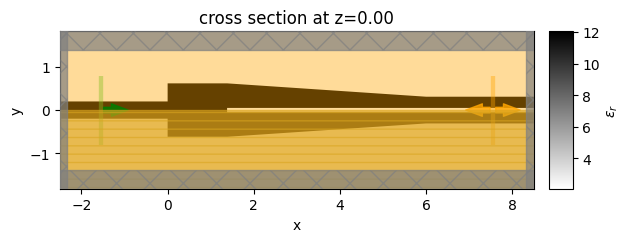

In [3]:
lda0 = 1.55  # central wavelength
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range of interest
freq0 = td.C_0 / lda0  # central frequency
freqs = td.C_0 / ldas  # frequency range of interest
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # frequency width of the source

h_si = 0.25  # thickness of the silicon layer
w_strip = 0.4  # width of the strip waveguide
w_slot = 0.62  # width of the slot waveguide
g = 0.1  # width of the slot

n_si = 3.47  # silicon refractive index
si = td.Medium(permittivity=n_si**2)
n_sio2 = 1.44  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)

L_mmi = 1.38  # length of the MMI section
W_mmi = 1.24  # width of the MMI section
L = 6  # length of the taper
buffer = 5  # buffer spacing before and after the converter

# define the poly slab vertices
vertices = [
    (-buffer, w_strip / 2),
    (0, w_strip / 2),
    (0, W_mmi / 2),
    (L_mmi, W_mmi / 2),
    (L, w_slot / 2),
    (L + buffer, w_slot / 2),
    (L + buffer, g / 2),
    (L_mmi, g / 2),
    (L_mmi, -g / 2),
    (L + buffer, -g / 2),
    (L + buffer, -w_slot / 2),
    (L, -w_slot / 2),
    (L_mmi, -W_mmi / 2),
    (0, -W_mmi / 2),
    (0, -w_strip / 2),
    (-buffer, -w_strip / 2),
]

# define the converter structure
converter = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h_si / 2, h_si / 2)), medium=si
)

# mode source to launch the TE0 mode at the strip waveguide before the converter
mode_spec = td.ModeSpec(num_modes=3, target_neff=n_si)
mode_source = td.ModeSource(
    center=(-lda0, 0, 0),
    size=(0, 4 * w_strip, 6 * h_si),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
    num_freqs=7,
)

# mode monitor to measure transmission at the slot waveguide after the converter
mode_monitor = td.ModeMonitor(
    center=(L + lda0, 0, 0),
    size=(0, 4 * w_strip, 6 * h_si),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

# field monitor to visualize field distribution at z=0
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

Lx = L + 3 * lda0  # the simulation domain size in the x direction
Ly = W_mmi + lda0  # the simulation domain size in the y direction
Lz = 10 * h_si  # the simulation domain size in the z direction
sim_size = (Lx, Ly, Lz)

run_time = 1e-12  # simulation run time

# construct the simulation
sim_3d = td.Simulation(
    center=(L / 2, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
    structures=[converter],
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
    symmetry=(0, -1, 1),
)

# plot the permittivity profile
sim_3d.plot_eps(z=0, freq=freq0)
plt.show()

Since the method that calculates the variational effective permittivity creates a 2D simulation from the given 3D simulation, there will likely be some objects not included in the 2D simulation, which will throw some warnings. Since we're okay with this, we'll suppress the warnings.

In [4]:
# Suppress warnings for some of the structures not being included in the 2D simulation
td.config.logging_level = 'ERROR'

Next we calculate the variational effective indices at different steps in our input wavelengths. We will then fit a dispersive material to this data using Tidy3D's FastDispersionFitter.<br><br>
To speed things up, we will reduce the number of times we need to solve for the mode, so we will downsample the wavelength points. Here we calculate the effective permittivity at every sixth wavelength.

In [5]:
step = 6
reference_point = (0,0)
waveguide_eps, background_eps = [], []
for wl in ldas[::step]: # at every step=sixth wavelength, calculate the effective permittivity
    waveguide_eps.append(var_eps_eff((0,0), reference_point, sim_3d, wavelength=wl))
    background_eps.append(var_eps_eff((0,1), reference_point, sim_3d, wavelength=wl))

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

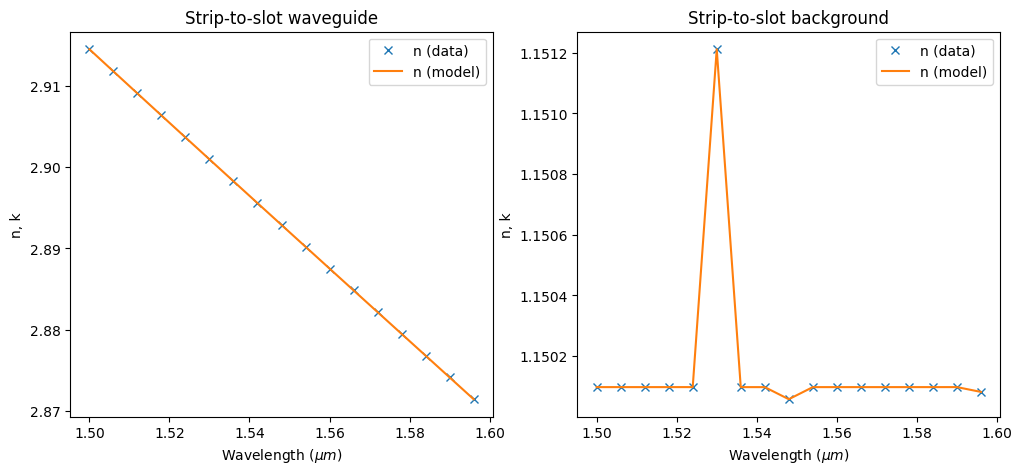

In [6]:
from tidy3d.plugins.dispersion import FastDispersionFitter

# fit the materials with the FastDispersionFitter using the calculated effective permittivities
waveguide_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(np.real(waveguide_eps)))
background_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(np.real(background_eps)))

# create the mediums using the material fit
waveguide_medium, rms_error = waveguide_fitter.fit()
background_medium, rms_error = background_fitter.fit()

# plot the material fit
fig, ax = plt.subplots(1, 2, figsize=(12,5))
waveguide_fitter.plot(waveguide_medium, ax=ax[0])
background_fitter.plot(background_medium, ax=ax[1])
ax[0].set_title("Strip-to-slot waveguide")
ax[1].set_title("Strip-to-slot background")
plt.show()

We now create the 2D simulation with the calculated 2D mediums:

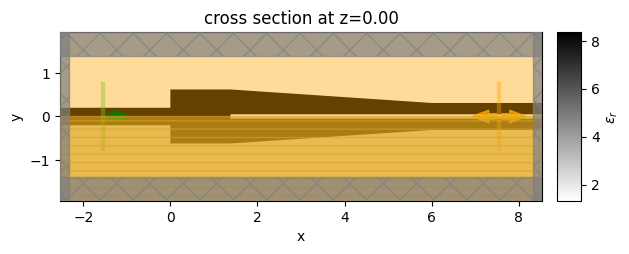

In [7]:
# Redo the structures that were in our 3D simulation with our calculated material approximations
new_structures = []
for structure in sim_3d.structures:
    new_structures.append(structure.updated_copy(medium=waveguide_medium))

# Update the size to 3D
new_size = list(sim_3d.size)
new_size[2] = 0

# Update the symmetry to 2D
new_symmetry = list(sim_3d.symmetry)
new_symmetry[2] = 0

# Create the 2D version of our 3D original
sim_2d = sim_3d.updated_copy(
    size=new_size,
    structures=new_structures,
    boundary_spec=sim_3d.boundary_spec.updated_copy(z=td.Boundary.periodic()),
    medium=background_medium,
    symmetry=new_symmetry
)

# Plot the 2D permittivity profile
sim_2d.plot_eps(z=0, freq=freq0)
plt.show()

Finally, we run both simulations.

In [8]:
sim_2d_data = web.run(sim_2d, task_name="var eps")
sim_3d_data = web.run(sim_3d, task_name="var eps")

10:10:02 PDT Created task 'var eps' with task_id                                
             'fdve-14d82fff-f836-4d0d-8c4c-f78367dcfe65' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=320678;https://tidy3d.simulation.cloud/workbench?taskId=fdve-14d82fff-f836-4d0d-8c4c-f78367dcfe65\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=962740;https://tidy3d.simulation.cloud/workbench?taskId=fdve-14d82fff-f836-4d0d-8c4c-f78367dcfe65\taskId]8;;\]8;id=320678;https://tidy3d.simulation.cloud/workbench?taskId=fdve-14d82fff-f836-4d0d-8c4c-f78367dcfe65\=]8;;\]8;id=70627;https://tidy3d.simulation.cloud/workbench?taskId=fdve-14d82fff-f836-4d0d-8c4c-f78367dcfe65\fdve]8;;\]8;id=320678;https://tidy3d.simulation.cloud/workbench?taskId=fdve-14d82fff-f836-4d0d-8c4c-f78367dcfe65\-14d82fff-f83]8;;\
             ]8;id=320678;https://tidy3d.simulation.cloud/workbench?taskId=fdve-14d82fff-f836-4d0d-8c4c-f78367dcfe65\6-4d0d-8c4c-f78367dcfe65']8;;\.

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

10:10:03 PDT status = success

10:10:04 PDT loading simulation from simulation_data.hdf5

             Created task 'var eps' with task_id                                
             'fdve-40d0bdb2-0307-4442-8b07-4e299d10fa47' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=179361;https://tidy3d.simulation.cloud/workbench?taskId=fdve-40d0bdb2-0307-4442-8b07-4e299d10fa47\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=860680;https://tidy3d.simulation.cloud/workbench?taskId=fdve-40d0bdb2-0307-4442-8b07-4e299d10fa47\taskId]8;;\]8;id=179361;https://tidy3d.simulation.cloud/workbench?taskId=fdve-40d0bdb2-0307-4442-8b07-4e299d10fa47\=]8;;\]8;id=735004;https://tidy3d.simulation.cloud/workbench?taskId=fdve-40d0bdb2-0307-4442-8b07-4e299d10fa47\fdve]8;;\]8;id=179361;https://tidy3d.simulation.cloud/workbench?taskId=fdve-40d0bdb2-0307-4442-8b07-4e299d10fa47\-40d0bdb2-030]8;;\
             ]8;id=179361;https://tidy3d.simulation.cloud/workbench?taskId=fdve-40d0bdb2-0307-4442-8b07-4e299d10fa47\7-4442-8b07-4e299d10fa47']8;;\.

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

             status = success

10:10:05 PDT loading simulation from simulation_data.hdf5

## Example 1 Result Comparison

Now that both the 2D and 3D simulations have run, we will compare their results to see how representative the 2D simluation is. The results are very similar compared to the variation coupling efficiency, showing that this 2D approximation retains a reasonable fidelity to the 3D version.

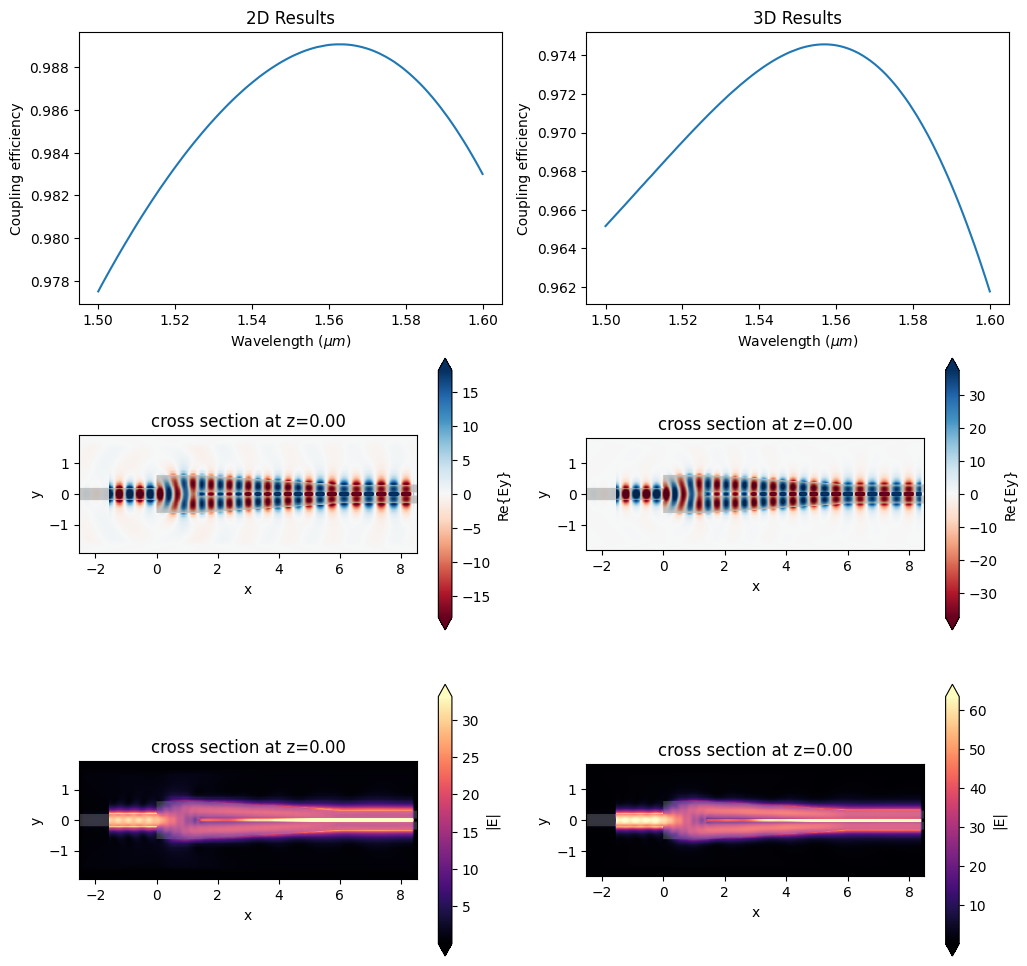

In [9]:
# Get the mode transmission for both simulations
T_2d = np.abs(sim_2d_data["mode"].amps.sel(mode_index=1,direction="+"))**2
T_3d = np.abs(sim_3d_data["mode"].amps.sel(mode_index=0,direction="+"))**2

fig, ax = plt.subplots(3, 2, figsize=(12,12))
ax[0][0].set_title("2D Results")
ax[0][0].set_xlabel("Wavelength ($\mu m$)")
ax[0][0].set_ylabel("Coupling efficiency")
ax[0][0].plot(ldas, T_2d) # plot the mode transmissions
sim_2d_data.plot_field(field_monitor_name="field", # plot the Ey field profile at central frequency
                       field_name="Ey",
                       val="real",
                       f=freq0,
                       ax=ax[1][0])
sim_2d_data.plot_field(field_monitor_name="field", # plot the |E| field profile at central frequency
                       field_name="E",
                       val="abs",
                       f=freq0,
                       ax=ax[2][0])
ax[0][1].set_title("3D Results")
ax[0][1].plot(ldas, T_3d)
ax[0][1].set_xlabel("Wavelength ($\mu m$)")
ax[0][1].set_ylabel("Coupling efficiency")
sim_3d_data.plot_field(field_monitor_name="field",
                       field_name="Ey",
                       val="real",
                       f=freq0,
                       ax=ax[1][1])
sim_3d_data.plot_field(field_monitor_name="field",
                       field_name="E",
                       val="abs",
                       f=freq0,
                       ax=ax[2][1])
plt.show()

## Example 2: Waveguide taper



As another example, we will compare results of the linear taper waveguide size converter in our [waveguide size converter notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguideSizeConverter/):

<img src="img/linear_taper.png" width="400" alt="Schematic of the linear taper">

As before, we'll copy the simulation, calculate the 2D mediums, create the 2D simulation, and compare results.

In [10]:
lda0 = 1.55
freq0 = td.C_0 / lda0
ldas = np.linspace(1.5, 1.6, 101)
freqs = td.C_0 / ldas
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))

n_si = 3.48
si = td.Medium(permittivity=n_si**2)
n_sio2 = 1.44
sio2 = td.Medium(permittivity=n_sio2**2)

In [11]:
w_in = 10  # input waveguied width
w_out = 0.5  # output waveguide width
t_wg = 0.11  # waveguide thickness
inf_eff = 1e3  # effective infinity of the model

# define the substrate structure
sub = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)
    ),
    medium=sio2,
)

# define function constructing the simulation given the taper length
def linear_taper_sim(L_t):

    # vertices of the taper
    vertices = [
        [-inf_eff, w_in / 2],
        [0, w_in / 2],
        [L_t, w_out / 2],
        [inf_eff, w_out / 2],
        [inf_eff, -w_out / 2],
        [L_t, -w_out / 2],
        [0, -w_in / 2],
        [-inf_eff, -w_in / 2],
    ]

    # construct the taper structure using a PolySlab
    linear_taper = td.Structure(
        geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t_wg)),
        medium=si,
    )

    # add a mode source that launches the TE0 mode at the input waveguide
    mode_source = td.ModeSource(
        center=(-lda0 / 2, 0, t_wg / 2),
        size=(0, 1.2 * w_in, 6 * t_wg),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
        mode_index=0,
    )

    # add field monitor to visualize the field distribution at z=t_wg/2
    field_monitor = td.FieldMonitor(
        center=(0, 0, t_wg / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
    )

    # add flux monitor to measure transmission to the output waveguide
    flux_monitor = td.FluxMonitor(
        center=(lda0 / 2 + L_t, 0, t_wg / 2),
        size=(0, 2 * w_out, 6 * t_wg),
        freqs=freqs,
        name="flux",
    )

    # define simulation domain size
    Lx = L_t + 2 * lda0
    Ly = w_in + 2 * lda0
    Lz = t_wg + 1.5 * lda0
    sim_size = (Lx, Ly, Lz)
    
    run_time = 3e-12

    # define simulation
    sim = td.Simulation(
        center=(L_t / 2, 0, t_wg),
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=[linear_taper, sub],
        sources=[mode_source],
        monitors=[field_monitor, flux_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(
            boundary=td.PML()
        ),
        symmetry=(0, -1, 0),
    )
    return sim

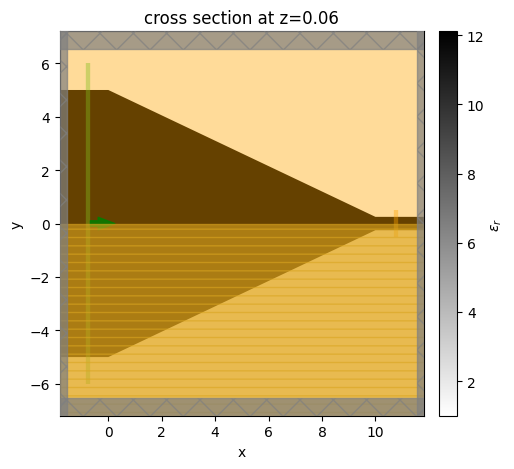

In [12]:
sim2_3d = linear_taper_sim(10) # create a simulation with a taper of size 10 microns

# plot the permittivity
sim2_3d.plot_eps(z=t_wg / 2, freq=freq0)
plt.show()

In [13]:
# This time we downsample at every third wavelength
step = 3
reference_point = (0,0)
waveguide_eps, background_eps = [], []
for wl in ldas[::step]: # calculate the variational effective permittivity at every third wavelength
    waveguide_eps.append(var_eps_eff((0,0), reference_point, sim2_3d, wavelength=wl))
    background_eps.append(var_eps_eff((10,4), reference_point, sim2_3d, wavelength=wl))

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

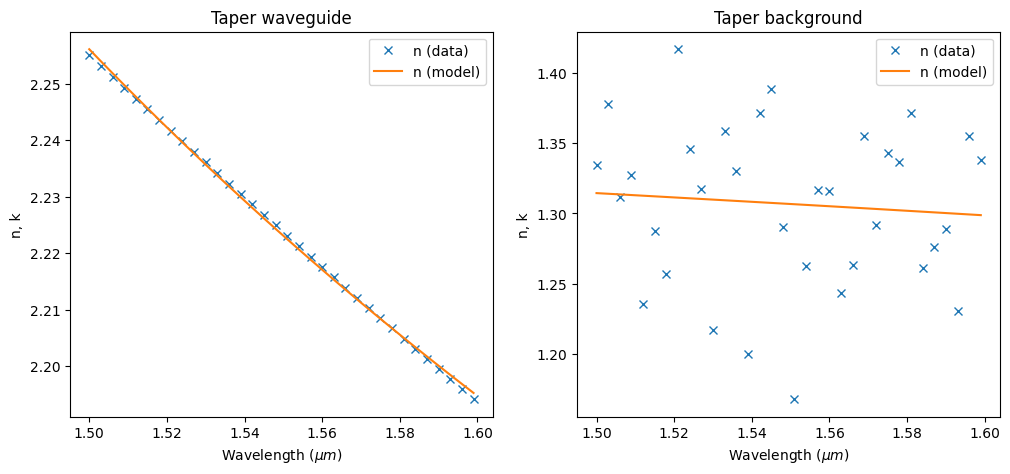

In [14]:
# again construct the materials fitting these calculated permittivities
waveguide_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(np.real(waveguide_eps)))
background_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(np.real(background_eps)))
waveguide_medium, rms_error = waveguide_fitter.fit()
background_medium, rms_error = background_fitter.fit()

# plot the material fits
fig, ax = plt.subplots(1, 2, figsize=(12,5))
waveguide_fitter.plot(waveguide_medium, ax=ax[0])
background_fitter.plot(background_medium, ax=ax[1])
ax[0].set_title("Taper waveguide")
ax[1].set_title("Taper background")
plt.show()

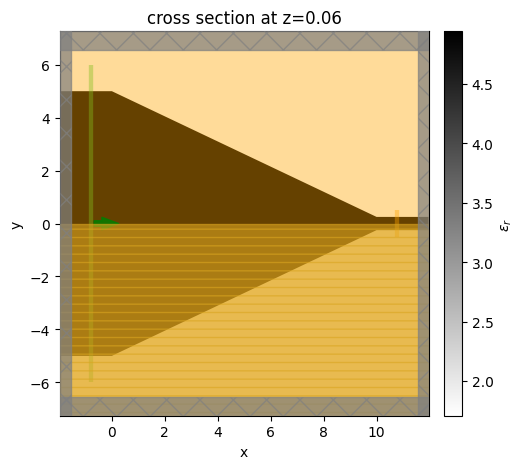

In [15]:
# in the same way as before, update the 3D simulation to a 2D simulation
new_structures = []
for structure in sim2_3d.structures:
    new_structures.append(structure.updated_copy(medium=waveguide_medium))

new_center = list(sim2_3d.center)
new_center[2] = t_wg / 2

new_size = list(sim2_3d.size)
new_size[2] = 0

sim2_2d = sim2_3d.updated_copy(
    center=new_center,
    size=new_size,
    structures=new_structures,
    boundary_spec=sim2_3d.boundary_spec.updated_copy(z=td.Boundary.periodic()),
    medium=background_medium,
    symmetry=new_symmetry
)

sim2_2d.plot_eps(z=t_wg/2, freq=freq0)
plt.show()

In [16]:
sim2_2d_data = web.run(sim2_2d, task_name="var eps 2 2D")
sim2_3d_data = web.run(sim2_3d, task_name="var eps 2 3D")

10:10:29 PDT Created task 'var eps 2 2D' with task_id                           
             'fdve-8587a87f-e6c6-400f-b51f-e13f7a95e7d7' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=402921;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8587a87f-e6c6-400f-b51f-e13f7a95e7d7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=175131;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8587a87f-e6c6-400f-b51f-e13f7a95e7d7\taskId]8;;\]8;id=402921;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8587a87f-e6c6-400f-b51f-e13f7a95e7d7\=]8;;\]8;id=882449;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8587a87f-e6c6-400f-b51f-e13f7a95e7d7\fdve]8;;\]8;id=402921;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8587a87f-e6c6-400f-b51f-e13f7a95e7d7\-8587a87f-e6c]8;;\
             ]8;id=402921;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8587a87f-e6c6-400f-b51f-e13f7a95e7d7\6-400f-b51f-e13f7a95e7d7']8;;\.

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

10:10:30 PDT status = success

             loading simulation from simulation_data.hdf5

             Created task 'var eps 2 3D' with task_id                           
             'fdve-73befbf0-3249-459b-9fe7-4802f868c2cc' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=405385;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73befbf0-3249-459b-9fe7-4802f868c2cc\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=826825;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73befbf0-3249-459b-9fe7-4802f868c2cc\taskId]8;;\]8;id=405385;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73befbf0-3249-459b-9fe7-4802f868c2cc\=]8;;\]8;id=618330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73befbf0-3249-459b-9fe7-4802f868c2cc\fdve]8;;\]8;id=405385;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73befbf0-3249-459b-9fe7-4802f868c2cc\-73befbf0-324]8;;\
             ]8;id=405385;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73befbf0-3249-459b-9fe7-4802f868c2cc\9-459b-9fe7-4802f868c2cc']8;;\.

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

10:10:31 PDT status = success

10:10:32 PDT loading simulation from simulation_data.hdf5

## Example 2 Result Comparison

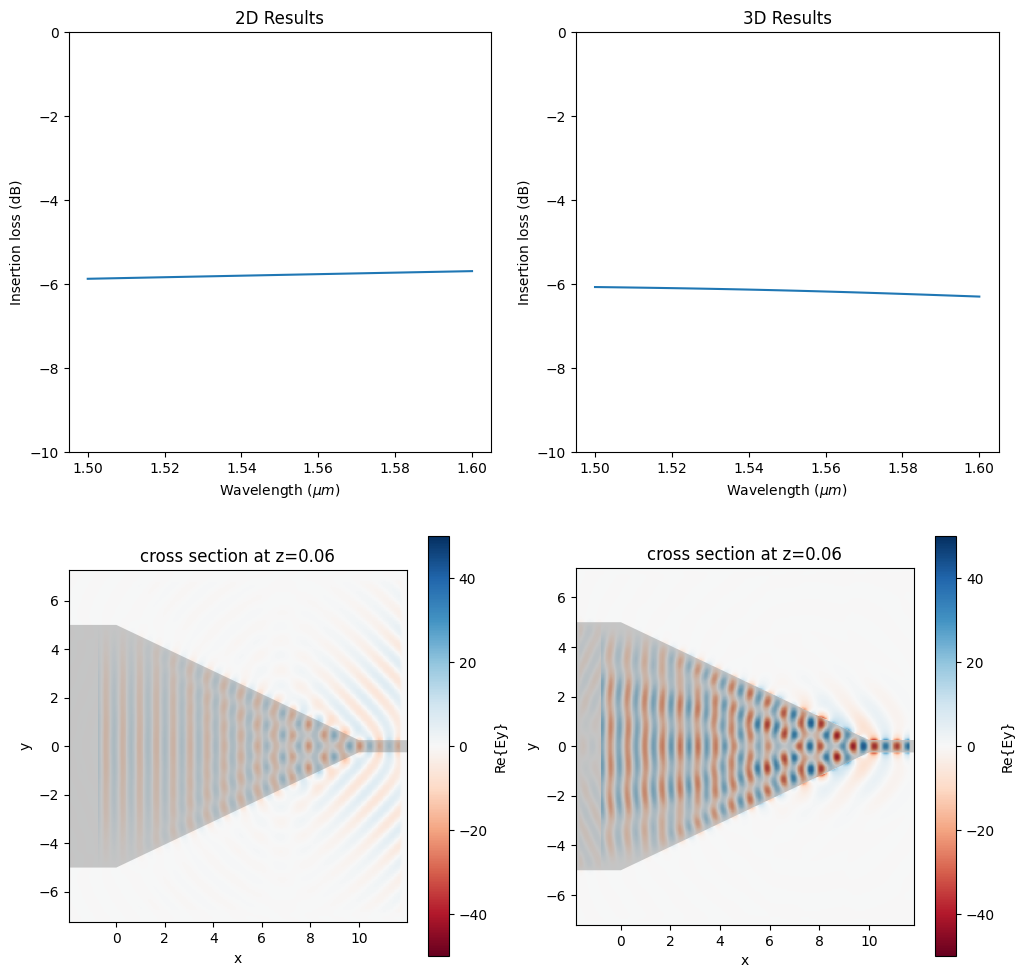

In [17]:
# get the transmission flux from both simulations
T2_2d = sim2_2d_data["flux"].flux
T2_3d = sim2_3d_data["flux"].flux

fig, ax = plt.subplots(2, 2, figsize=(12,12))
ax[0][0].set_title("2D Results")
ax[0][0].set_ylim((-10,0))
ax[0][0].set_xlabel("Wavelength ($\mu m$)")
ax[0][0].set_ylabel("Insertion loss (dB)")
ax[0][0].plot(ldas, 10*np.log10(T2_2d)) # calculate and plot the insertion loss
sim2_2d_data.plot_field(field_monitor_name="field",
                       field_name="Ey",
                       f=freq0,
                       ax=ax[1][0],
                       vmin=-50,
                       vmax=50)
ax[0][1].set_title("3D Results")
ax[0][1].set_ylim((-10,0))
ax[0][1].set_xlabel("Wavelength ($\mu m$)")
ax[0][1].set_ylabel("Insertion loss (dB)")
ax[0][1].plot(ldas, 10*np.log10(T2_3d))
sim2_3d_data.plot_field(field_monitor_name="field",
                       field_name="Ey",
                       f=freq0,
                       ax=ax[1][1],
                       vmin=-50,
                       vmax=50)
plt.show()

## Example 3: Y-junction

Next we'll use this method to construct a 2-dimensional analogue of a Y junction, where the 3D version uses a dispersive material model. The Y junction design is taken from [this example notebook](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/YJunction.html):

<img src="img/y_junction_schematic.png" width="600" alt="Schematic of the waveguide Y junction">

In [18]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

# import material from pre-saved material data in Tidy3D's material library
si = td.material_library["cSi"]["Palik_Lossless"]
sio2 = td.material_library["SiO2"]["Palik_Lossless"]

In [19]:
t = 0.22  # thickness of the silicon layer

# width of the 13 segments
w1 = 0.5
w2 = 0.5
w3 = 0.6
w4 = 0.7
w5 = 0.9
w6 = 1.26
w7 = 1.4
w8 = 1.4
w9 = 1.4
w10 = 1.4
w11 = 1.31
w12 = 1.2
w13 = 1.2

l_in = 1  # input waveguide length
l_junction = 2  # length of the junction
l_bend = 6  # horizontal length of the waveguide bend
h_bend = 2  # vertical offset of the waveguide bend
l_out = 1  # output waveguide length
inf_eff = 100  # effective infinity

x = np.linspace(l_in, l_in + l_junction, 13)  # x coordinates of the top edge vertices
y = np.array(
    [w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13]
)  # y coordinates of the top edge vertices

# using concatenate to include bottom edge vertices
x = np.concatenate((x, np.flipud(x)))
y = np.concatenate((y / 2, -np.flipud(y / 2)))

# stacking x and y coordinates to form vertices pairs
vertices = np.transpose(np.vstack((x, y)))

junction = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t)), medium=si
)

x_start = l_in + l_junction  # x coordinate of the starting point of the waveguide bends

x = np.linspace(x_start, x_start + l_bend, 100)  # x coordinates of the top edge vertices

y = (
    (x - x_start) * h_bend / l_bend
    - h_bend * np.sin(2 * np.pi * (x - x_start) / l_bend) / (np.pi * 2)
    + w13 / 2
    - w1 / 2
)  # y coordinates of the top edge vertices

# adding the last point to include the straight waveguide at the output
x = np.append(x, inf_eff)
y = np.append(y, y[-1])

# add path to the cell
cell = gdstk.Cell("bends")
cell.add(gdstk.FlexPath(x + 1j * y, w1, layer=1, datatype=0))  # top waveguide bend
cell.add(gdstk.FlexPath(x - 1j * y, w1, layer=1, datatype=0))  # bottom waveguide bend

# define top waveguide bend structure
wg_bend_1 = td.Structure(
    geometry=td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(0, t),
    )[0],
    medium=si,
)

# define bottom waveguide bend structure
wg_bend_2 = td.Structure(
    geometry=td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(0, t),
    )[1],
    medium=si,
)

# straight input waveguide
wg_in = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -w1 / 2, 0), rmax=(l_in, w1 / 2, t)),
    medium=si,
)

# the entire model is the collection of all structures defined so far
y_junction = [wg_in, junction, wg_bend_1, wg_bend_2]

Lx = l_in + l_junction + l_out + l_bend  # simulation domain size in x direction
Ly = w13 + 2 * h_bend + 1.5 * lda0  # simulation domain size in y direction
Lz = 10 * t  # simulation domain size in z direction
sim_size = (Lx, Ly, Lz)

# add mode source as excitation
mode_spec = td.ModeSpec(num_modes=1, target_neff=3.5)
mode_source = td.ModeSource(
    center=(l_in / 2, 0, t / 2),
    size=(0, 4 * w1, 6 * t),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# add mode monitor to measure transmission at the output waveguide
mode_monitor = td.ModeMonitor(
    center=(l_in + l_junction + l_bend + l_out / 2, w13 / 2 - w1 / 2 + h_bend, t / 2),
    size=(0, 4 * w1, 6 * t),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

# add field monitor to visualize field distribution at z=t/2
field_monitor = td.FieldMonitor(
    center=(0, 0, t / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

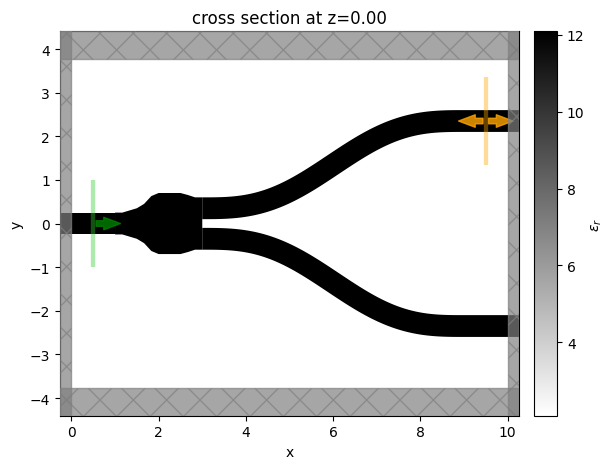

In [20]:
run_time = 5e-13

simY_3d = td.Simulation(
    center=(Lx / 2, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=y_junction,
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
)

simY_3d.plot_eps(z=0, freq=freq0)
plt.show()

In [21]:
# again calculate the effective permittivity at every third wavelength
step = 3
reference_point = (2,0)
waveguide_eps, background_eps = [], []
for wl in ldas[::step]:
    waveguide_eps.append(var_eps_eff((2,0), reference_point, simY_3d, wavelength=wl))
    background_eps.append(var_eps_eff((6,0), reference_point, simY_3d, wavelength=wl))

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

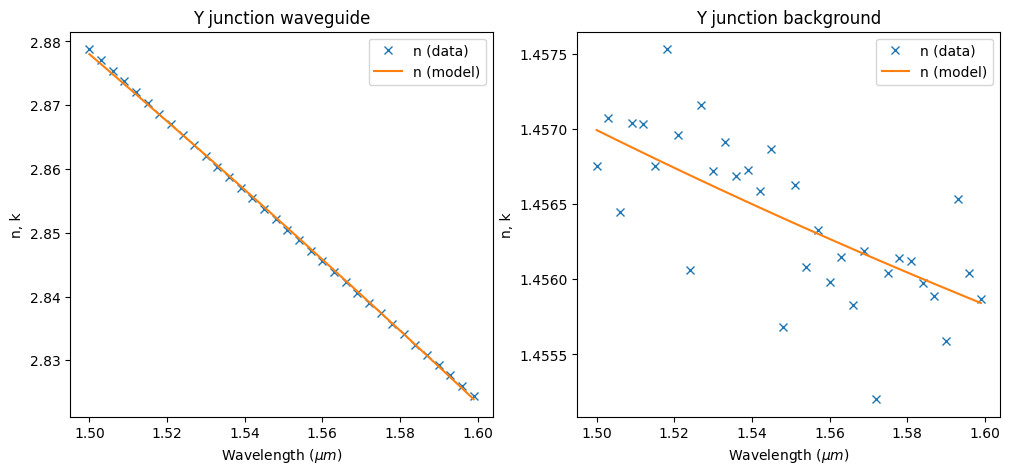

In [22]:
# again fit and construct the materials from the calculated permittivities
waveguide_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(np.real(waveguide_eps)))
background_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(np.real(background_eps)))
waveguide_medium, rms_error = waveguide_fitter.fit()
background_medium, rms_error = background_fitter.fit()

fig, ax = plt.subplots(1, 2, figsize=(12,5))
waveguide_fitter.plot(waveguide_medium, ax=ax[0])
background_fitter.plot(background_medium, ax=ax[1])
ax[0].set_title("Y junction waveguide")
ax[1].set_title("Y junction background")
plt.show()

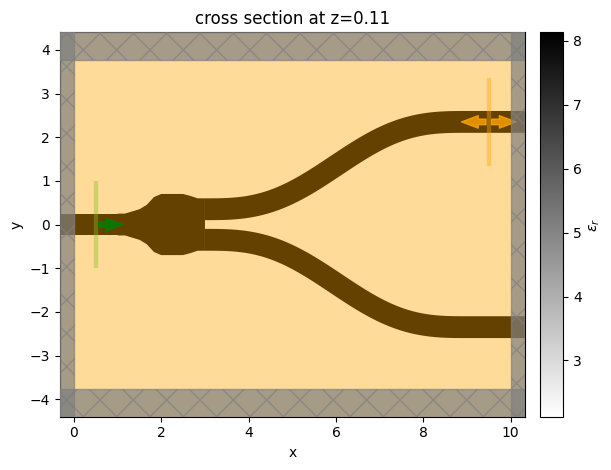

In [23]:
# again update the 3D simulation into a 2D simulation
new_structures = []
for structure in simY_3d.structures:
    new_structures.append(structure.updated_copy(medium=waveguide_medium))

new_size = list(simY_3d.size)
new_size[2] = 0

simY_2d = simY_3d.updated_copy(
    center=(Lx / 2, 0, t/2),
    size=new_size,
    structures=new_structures,
    boundary_spec=simY_3d.boundary_spec.updated_copy(z=td.Boundary.periodic()),
    medium=background_medium,
)

simY_2d.plot_eps(z=t/2, freq=freq0)
plt.show()

In [24]:
simY_2d_data = web.run(simY_2d, task_name="var eps Y 2D")
simY_3d_data = web.run(simY_3d, task_name="var eps Y 2D")

10:10:54 PDT Created task 'var eps Y 2D' with task_id                           
             'fdve-1074d989-1856-4736-9c80-d412ee7d287d' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=46729;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1074d989-1856-4736-9c80-d412ee7d287d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=778625;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1074d989-1856-4736-9c80-d412ee7d287d\taskId]8;;\]8;id=46729;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1074d989-1856-4736-9c80-d412ee7d287d\=]8;;\]8;id=603602;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1074d989-1856-4736-9c80-d412ee7d287d\fdve]8;;\]8;id=46729;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1074d989-1856-4736-9c80-d412ee7d287d\-1074d989-185]8;;\
             ]8;id=46729;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1074d989-1856-4736-9c80-d412ee7d287d\6-4736-9c80-d412ee7d287d']8;;\.

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

10:10:55 PDT status = success

10:10:56 PDT loading simulation from simulation_data.hdf5

             Created task 'var eps Y 2D' with task_id                           
             'fdve-68ef4a6a-fa38-432b-b525-31c5ba092c25' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=711241;https://tidy3d.simulation.cloud/workbench?taskId=fdve-68ef4a6a-fa38-432b-b525-31c5ba092c25\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=486244;https://tidy3d.simulation.cloud/workbench?taskId=fdve-68ef4a6a-fa38-432b-b525-31c5ba092c25\taskId]8;;\]8;id=711241;https://tidy3d.simulation.cloud/workbench?taskId=fdve-68ef4a6a-fa38-432b-b525-31c5ba092c25\=]8;;\]8;id=810408;https://tidy3d.simulation.cloud/workbench?taskId=fdve-68ef4a6a-fa38-432b-b525-31c5ba092c25\fdve]8;;\]8;id=711241;https://tidy3d.simulation.cloud/workbench?taskId=fdve-68ef4a6a-fa38-432b-b525-31c5ba092c25\-68ef4a6a-fa3]8;;\
             ]8;id=711241;https://tidy3d.simulation.cloud/workbench?taskId=fdve-68ef4a6a-fa38-432b-b525-31c5ba092c25\8-432b-b525-31c5ba092c25']8;;\.

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

             status = success

10:10:57 PDT loading simulation from simulation_data.hdf5

## Example 3 Result Comparison

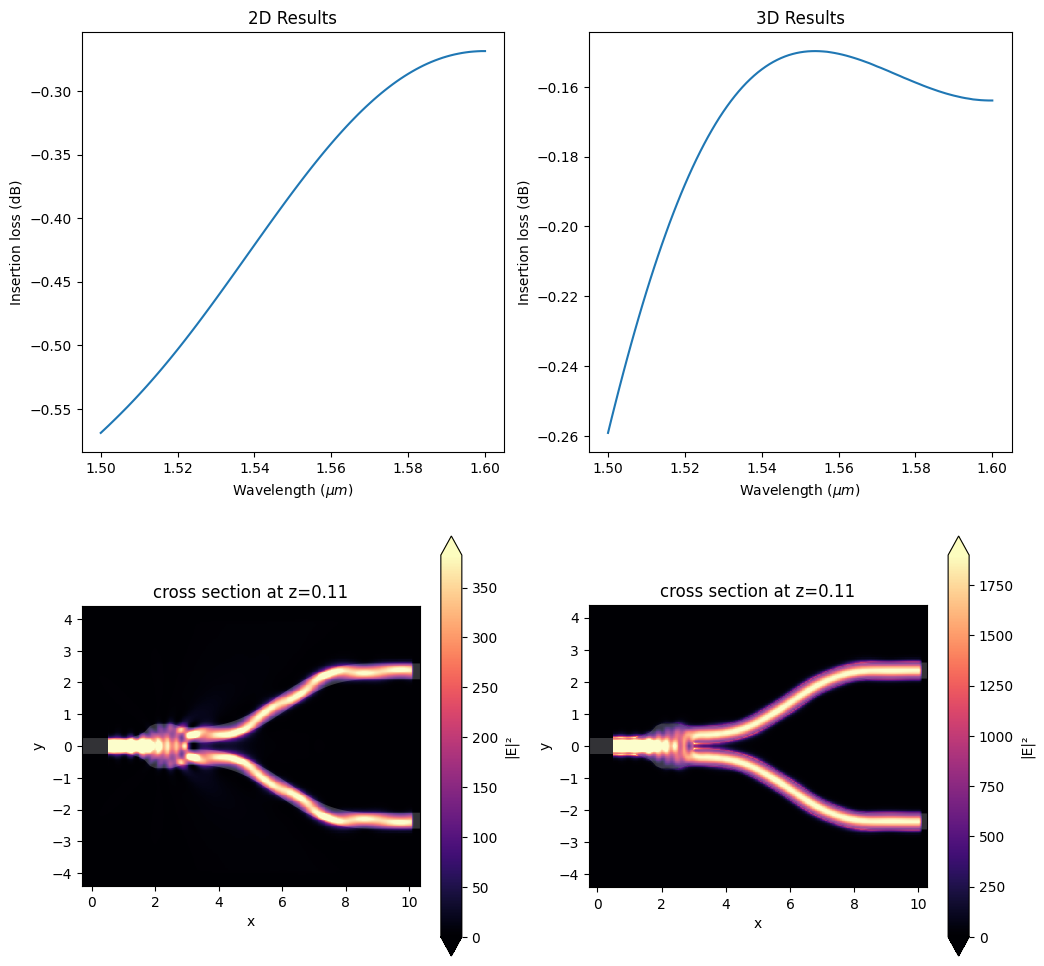

In [25]:
# calculate insertion loss from mode transmission from both simulations
amp2d = simY_2d_data["mode"].amps.sel(mode_index=0, direction="+")
amp3d = simY_3d_data["mode"].amps.sel(mode_index=0, direction="+")
loss2d = 10*np.log10(2*np.abs(amp2d)**2)
loss3d = 10*np.log10(2*np.abs(amp3d)**2)

fig, ax = plt.subplots(2, 2, figsize=(12,12))

ax[0][0].set_title("2D Results")
ax[0][0].plot(ldas, loss2d)
ax[0][0].set_xlabel("Wavelength ($\mu m$)")
ax[0][0].set_ylabel("Insertion loss (dB)")
simY_2d_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2", f=freq0, ax=ax[1][0])

ax[0][1].set_title("3D Results")
ax[0][1].plot(ldas, loss3d)
ax[0][1].set_xlabel("Wavelength ($\mu m$)")
ax[0][1].set_ylabel("Insertion loss (dB)")
simY_3d_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2", f=freq0, ax=ax[1][1])

plt.show()

## Summary

For transmissions and other relevant quantities for components such as these, this 2D method returns rather similar results to its 3D counterpart, and should allow for a cheap way to screen early designs of such components.